## Tutorial on the basic usage of `qf`

In [1]:
import qf.cc
import qf.graphs
import qf.morph
import qf.qastar
import qf.qzss
import qf.util

In [2]:
G = qf.util.read_graph("examples/graph.tsv", coordinates=qf.util.read_coordinates("examples/coordinates.txt"), weights=True)

Let us visualize the graph G:

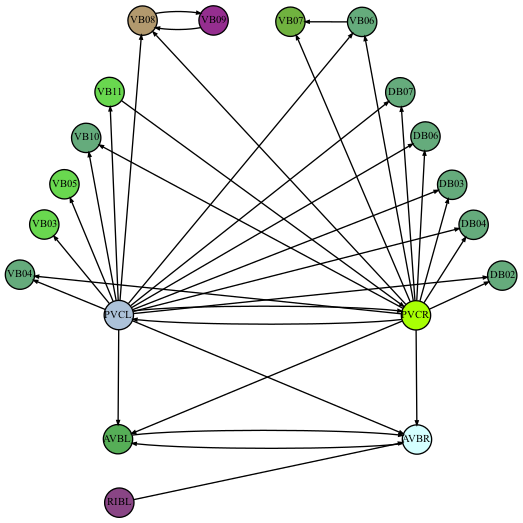

In [4]:
qf.graphs.visualize(G, colors=qf.cc.cardon_crochemore(G), scale=0.5)

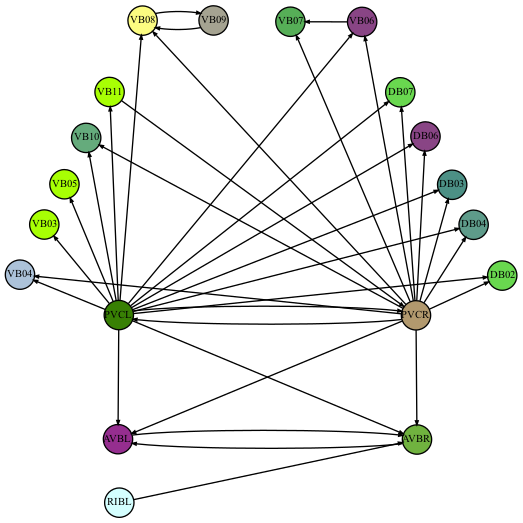

In [8]:
qf.graphs.visualize(G, colors=qf.cc.cardon_crochemore(qf.graphs.multiplex(G, .01)), scale=0.5)

Equivalence relations are usually represented as dictionaries, whose keys are the graph nodes and whose values are the classes (or clusters).
The actual values are not important: the only relevant thing is whether two nodes have the same value (i.e., are in the 
same cluster) or not. Here are the clusters of Cardon-Crochemore.

In [7]:
print(cc)

{'AVBL': 2, 'AVBR': 7, 'PVCL': 9, 'PVCR': 6, 'RIBL': 4, 'DB02': 5, 'DB03': 5, 'DB04': 5, 'DB06': 5, 'DB07': 5, 'VB05': 0, 'VB10': 5, 'VB03': 0, 'VB04': 5, 'VB06': 5, 'VB08': 8, 'VB11': 0, 'VB07': 3, 'VB09': 1}


We can use this dictionary to colour the graph, as follows:

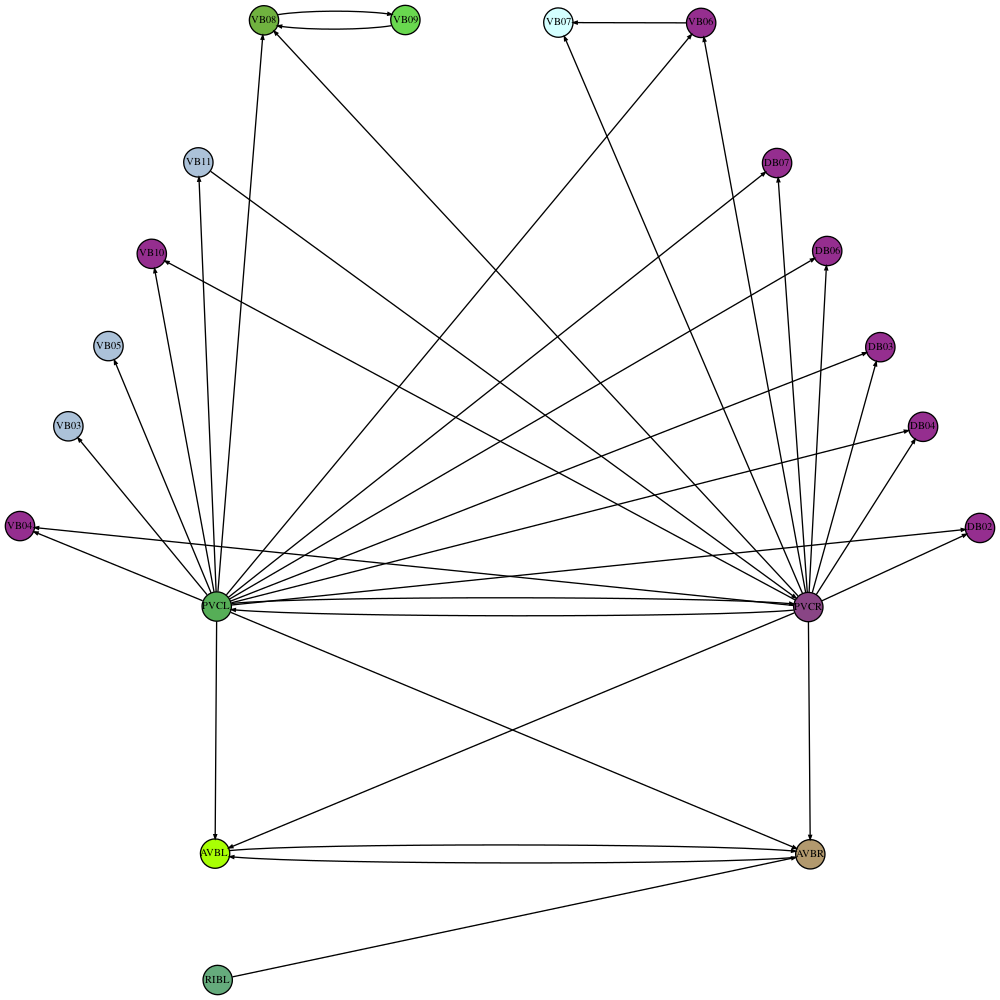

In [8]:
qf.graphs.visualize(G, cc)

In the case of this dataset, we have an idea of how nodes should be clustered. This knowledge (that we shall hereafter
call *ground truth*) is stored in a file, and we can conveniently read it as follows:

In [9]:
gt = qf.util.read_label("examples/ground-truth.tsv")

If we want to compare two equivalence relations we can use the [adjusted Normalized Mutual Information (NMI)](https://en.wikipedia.org/wiki/Adjusted_mutual_information) score:

In [10]:
print(qf.util.nmi(cc, gt))

0.5431911530687388


Let us consider the matrix of Ordered Edit Distance between the views of nodes truncated at a certain depth (here we use 4). The function that does so also conveniently returns the list of nodes (to have a map from row/column numbers to nodes) and a dictionary (to have the reverse map).

In [11]:
depth = 4
OEDM, nodes, indices = qf.qzss.cached_zss_dist_matrix(G, depth)

Here is, for instance, the OED between two nodes.

In [12]:
print(OEDM[indices["AVBL"], indices["AVBR"]])

4.0


We can also compute the Unordered Edit Distance matrix, at the same depth. Since this computation takes worst-case exponential
time, we can specify a time-out and that when the computation of a given entry has been timed out one should use the OEDM
matrix instead.

In [13]:
UEDM, nodes, indices = qf.qastar.qastar_dist_matrix(G, depth, Msubs=OEDM, max_milliseconds=60*1000)

18/05/2021 17:12:58 [qastar_dist_matrix, line   98]: uted_aster stopped, substituted with 20.0
18/05/2021 17:13:01 [qastar_dist_matrix, line   98]: uted_aster stopped, substituted with 20.0
18/05/2021 17:13:04 [qastar_dist_matrix, line   98]: uted_aster stopped, substituted with 10.0
18/05/2021 17:13:04 [qastar_dist_matrix, line   98]: uted_aster stopped, substituted with 11.0
18/05/2021 17:13:04 [qastar_dist_matrix, line  105]: Stopped 2.34% of the times


Here is the UED between the same two nodes.

In [14]:
print(UEDM[indices["AVBL"], indices["AVBR"]])

3.0


We now perform agglomerative clustering using the matrix UEDM just computed. We have to specify the minimum (4) and maximum
(`G.number_of_nodes()`) numbers of clusters to be used. The function will optimize based on the [Silhouette Coefficient](https://en.wikipedia.org/wiki/Silhouette_(clustering)).
The resulting clustering is turned into a standard dictionary by the second function.

In [15]:
c, _, _, _ = qf.qastar.agclust_optcl(G, depth, 4, G.number_of_nodes(), M=UEDM)
agglc = qf.qastar.agclust2dict(c, UEDM, nodes, indices)

Here is the clustering, its NMI and its visualization as colouring.

In [16]:
print(agglc)
print(qf.util.nmi(agglc, gt))

{'AVBL': 0, 'AVBR': 0, 'PVCL': 6, 'PVCR': 8, 'RIBL': 4, 'DB02': 1, 'DB03': 1, 'DB04': 1, 'DB06': 1, 'DB07': 1, 'VB05': 2, 'VB10': 1, 'VB03': 2, 'VB04': 1, 'VB06': 1, 'VB08': 5, 'VB11': 2, 'VB07': 7, 'VB09': 3}
0.5938505821242616


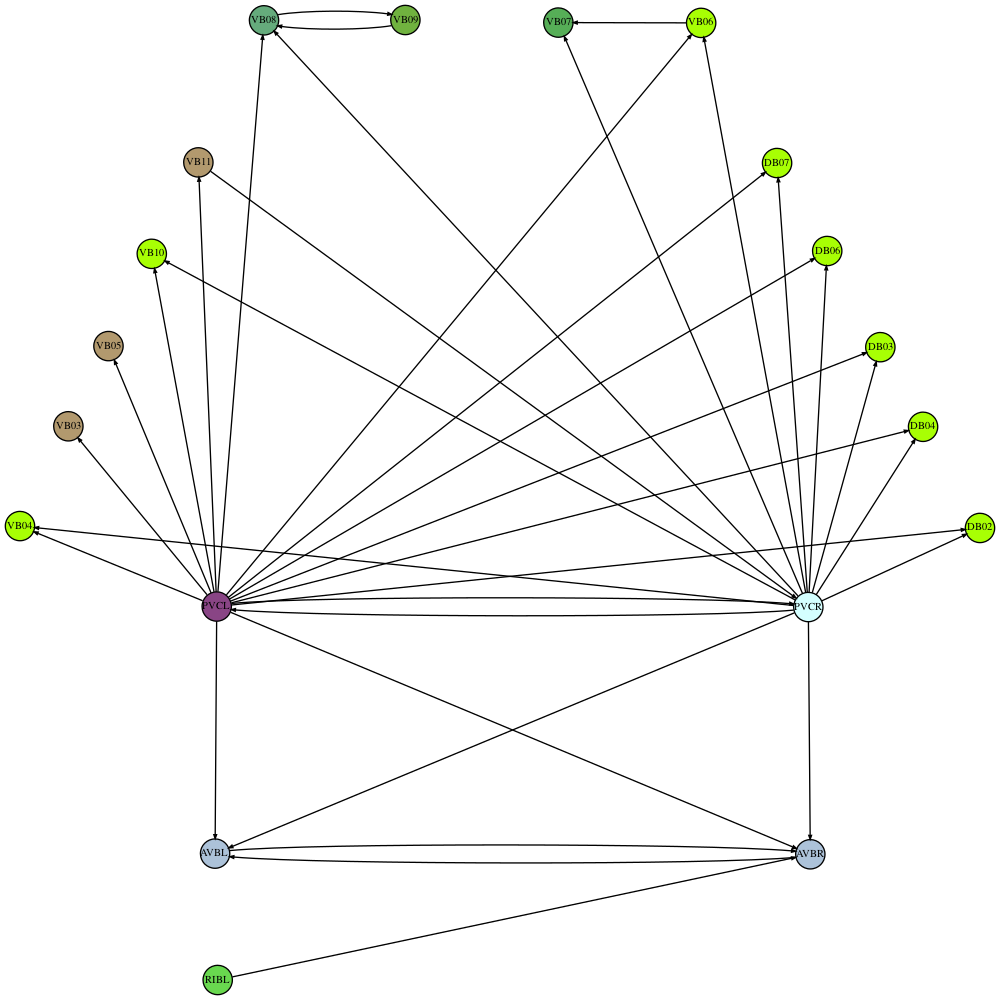

In [17]:
qf.graphs.visualize(G, agglc)

Now we compute the optimal quasi-fibration from G with this equivalence classes as node fibres. The function returns the base graph and the fibration.

In [18]:
B, f = qf.morph.qf_build(G, agglc)

Here is the excess and deficiency of this quasi-fibration.

In [19]:
print(qf.morph.excess_deficiency(f, G, B))

(0, 1)


Now, we show how to repair G so that f is transformed into a fibration. The function returns the new repaired graph and
the new morphism (an epimorphism).

In [20]:
Gp, fp = qf.morph.repair(f, G, B, verbose=True)

Adding arc new_arc_906691059: RIBL -> AVBL (mapped to 4_0_0)


As a final step, we take the repaired graph Gp and perform the Cardon-Crochemore algorithm on it. This step can further improve the clustering.

In [21]:
reduced_agglc = qf.cc.cardon_crochemore(Gp)

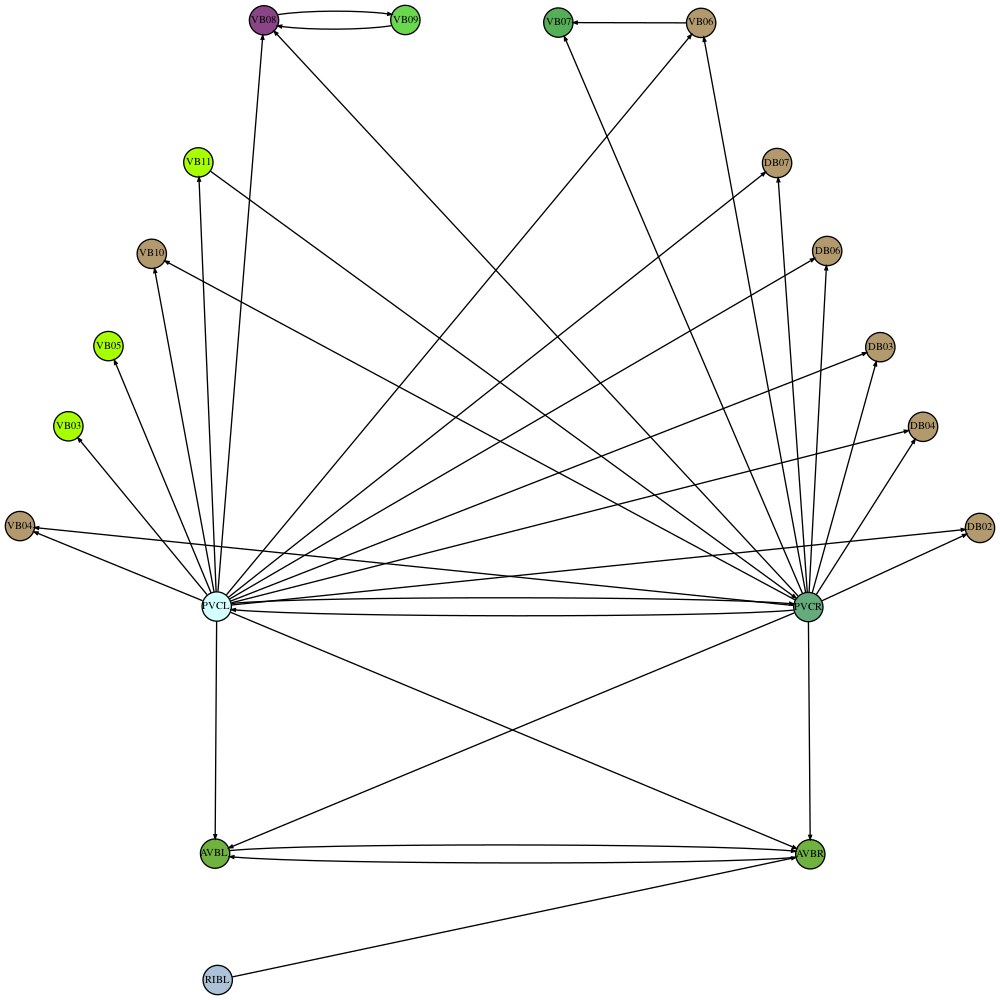

In [22]:
qf.graphs.visualize(G, reduced_agglc)